In [1]:
%pip install hdbscan

     |████████████████████████████████| 6.4MB 5.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311657 sha256=7240bd72e776fe2cd56ed8896f21482a5ec5fad94af45cf6e30bbceb16de808c
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
%matplotlib inline 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.stats as stats
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE

In [3]:
URL = "https://raw.githubusercontent.com/devrepublik/data-science-course/master/data/clustering/CreditCardUsers.csv"
credit_df = pd.read_csv(URL)
credit_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
credit_df['MINIMUM_PAYMENTS'] = credit_df['MINIMUM_PAYMENTS'].fillna(credit_df['MINIMUM_PAYMENTS'].mean())

In [5]:
credit_df['CREDIT_LIMIT'] = credit_df['CREDIT_LIMIT'].fillna(credit_df['CREDIT_LIMIT'].mean())

In [6]:
X = credit_df.loc[:, credit_df.columns != 'CUST_ID']

In [7]:
scaler = StandardScaler()
X[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE']] = scaler.fit_transform(X[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [8]:
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960433,-0.528979,-3.109675e-01,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688639,0.818642,8.931021e-02,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826062,-0.383805,-1.016632e-01,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826062,-0.598688,-5.366135e-16,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905464,-0.364368,-2.657913e-01,-0.525551,0.36068


In [9]:
model_kmeans = KMeans(
    n_clusters=4,
    n_init=50,
    max_iter=500,
    random_state=42
)
model_kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=4, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [10]:
clust_num = model_kmeans.predict(X)
X['cluster_kmeans'] = clust_num

In [11]:
model_dbscan = DBSCAN(eps=5, min_samples=50)
model_dbscan.fit(X.iloc[:, X.columns != 'cluster_kmeans'])

DBSCAN(algorithm='auto', eps=5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=50, n_jobs=None, p=None)

In [12]:
clust_num = pd.DataFrame( data = model_dbscan.labels_, columns = ['clust_num'])

In [13]:
clust_num.value_counts()

clust_num
 0           8863
-1             87
dtype: int64

In [14]:
X['cluster_DBSCAN'] = clust_num

In [21]:
pca = PCA(n_components = 2)

principal_components = pca.fit_transform(X.iloc[:, ~X.columns.isin(['cluster_kmeans', 'cluster_DBSCAN'])] )

df_pca = pd.DataFrame(
        data=principal_components, 
        columns=[f'pc-{k}' for k in range(1, pca.n_components_+1)]
    )

df_pca.head()

,pc-1,pc-2
0,-1.682220,-1.076446
1,-1.138298,2.506478
2,0.969695,-0.383494
3,-0.873627,0.043177
4,-1.599433,-0.688578


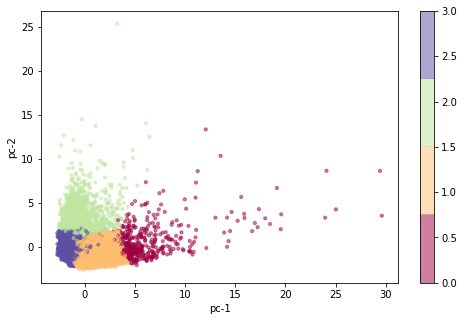

In [22]:
df_pca["cluster"] = X['cluster_kmeans']

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

In [23]:
TSNE_cards = TSNE(n_components=2).fit_transform(X.iloc[:, ~X.columns.isin(['cluster_kmeans', 'cluster_DBSCAN'])])

In [24]:
TSNE_cards

array([[-29.81503  , -33.6506   ],
       [ 51.61146  , -27.19025  ],
       [ 22.473251 ,  27.688723 ],
       ...,
       [-51.6231   ,   1.9253109],
       [-14.31602  , -50.32036  ],
       [-19.956255 , -47.925415 ]], dtype=float32)

In [25]:
TSNE_cards = pd.DataFrame (data = TSNE_cards, columns = ['tsne-1', 'tsne-2'])


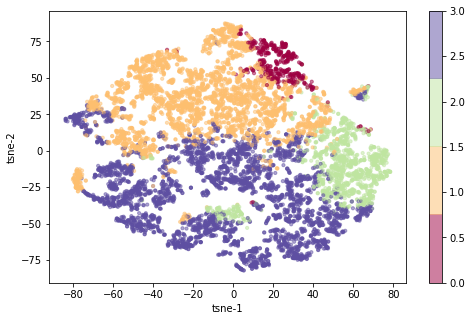

In [26]:
TSNE_cards["cluster"] = X['cluster_kmeans']

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

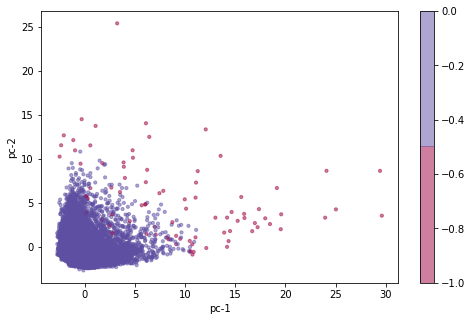

In [27]:
df_pca["cluster"] = X['cluster_DBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

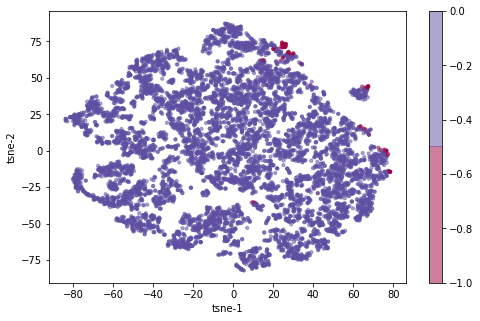

In [28]:
TSNE_cards["cluster"] = X['cluster_DBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

In [44]:
model_hdbscan = HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
model_hdbscan.fit(X.iloc[:, ~X.columns.isin(['cluster_kmeans', 'cluster_DBSCAN'])])

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=20, min_samples=None, p=None,
        prediction_data=False)

In [45]:
clust_num = pd.DataFrame( data = model_hdbscan.labels_, columns = ['clust_num'])

In [46]:
clust_num.value_counts()

clust_num
-1           6903
 1           1751
 3            221
 2             43
 0             32
dtype: int64

In [47]:
X['cluster_HDBSCAN'] = clust_num

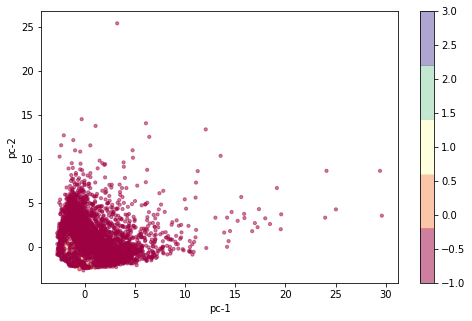

In [48]:
df_pca["cluster"] = X['cluster_HDBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

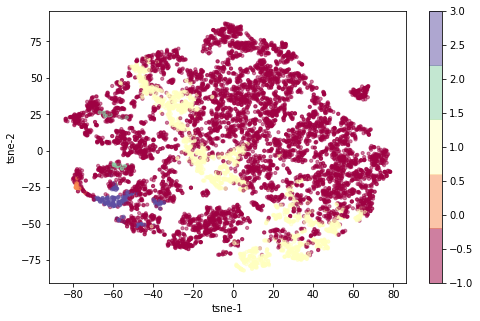

In [50]:
TSNE_cards["cluster"] = X['cluster_HDBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

**EducationIndicators2014**

In [ ]:
EducationIndicators2014

In [51]:
URL = "https://raw.githubusercontent.com/devrepublik/data-science-course/master/data/clustering/EducationIndicators2014.csv"
education_indicators = pd.read_csv(URL)
education_indicators.head()

,Country Name,PPT,GDP,PRPE,OOCP,ESE,EPE,UNEMP,LEB,TDP
0,Albania,2893654,1.321986e+10,0.73,7097,333291,195720,16.10,77.83,5
1,Arab World,384222592,2.889750e+12,6.42,6827541,30972246,45126932,11.52,70.57,6
2,United Arab Emirates,9086139,4.019580e+11,0.22,14611,411040,409776,3.60,77.37,5
3,Azerbaijan,9535079,7.519801e+10,0.16,22821,949294,517708,5.20,70.76,4
4,Burundi,10816860,3.093647e+09,24.25,69246,583308,2046794,6.90,56.69,6


In [52]:
X = education_indicators.loc[:, education_indicators.columns != 'Country Name']

In [53]:
scaler = StandardScaler()
X[['PPT', 'GDP', 'PRPE', 'OOCP', 'ESE', 'EPE', 'UNEMP', 'LEB', 'TDP']] = scaler.fit_transform(X[['PPT', 'GDP', 'PRPE', 'OOCP', 'ESE', 'EPE', 'UNEMP', 'LEB', 'TDP']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [54]:
model_kmeans = KMeans(
    n_clusters=3,
    n_init=50,
    max_iter=500,
    random_state=42
)
model_kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=3, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [55]:
clust_num = model_kmeans.predict(X)
X['cluster_kmeans'] = clust_num

In [113]:
model_dbscan = DBSCAN(eps=1.6, min_samples=5)
model_dbscan.fit(X.iloc[:, X.columns != 'cluster_kmeans'])

DBSCAN(algorithm='auto', eps=1.6, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [114]:
clust_num = pd.DataFrame( data = model_dbscan.labels_, columns = ['clust_num'])

In [115]:
clust_num.value_counts()

clust_num
 0           72
-1           20
 2           10
 1            5
dtype: int64

In [116]:
X['cluster_DBSCAN'] = clust_num

In [117]:
pca = PCA(n_components = 2)

principal_components = pca.fit_transform(X.iloc[:, ~X.columns.isin(['cluster_kmeans', 'cluster_DBSCAN'])] )

df_pca = pd.DataFrame(
        data=principal_components, 
        columns=[f'pc-{k}' for k in range(1, pca.n_components_+1)]
    )

df_pca.head()

,pc-1,pc-2
0,-1.340927,-1.372862
1,-0.307596,0.517740
2,-1.077108,-1.186317
3,-1.224506,-1.169052
4,-0.777933,4.205126


In [118]:
TSNE_cards = TSNE(n_components=2).fit_transform(X.iloc[:, ~X.columns.isin(['cluster_kmeans', 'cluster_DBSCAN'])])

In [119]:
TSNE_cards = pd.DataFrame (data = TSNE_cards, columns = ['tsne-1', 'tsne-2'])


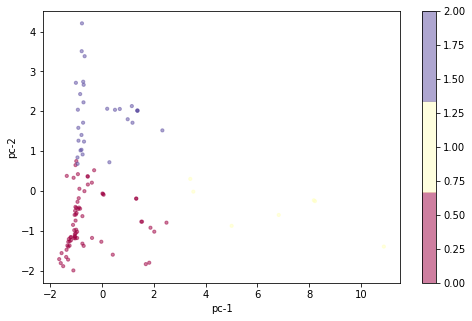

In [120]:
df_pca["cluster"] = X['cluster_kmeans']

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

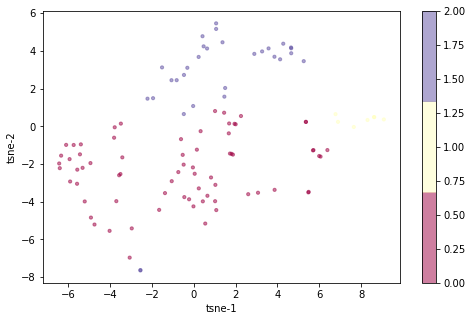

In [121]:
TSNE_cards["cluster"] = X['cluster_kmeans']

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

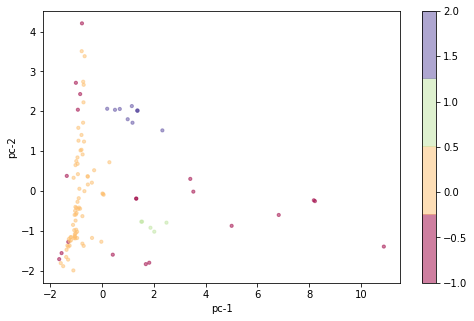

In [122]:
df_pca["cluster"] = X['cluster_DBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

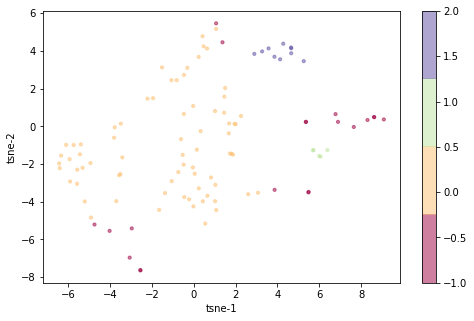

In [123]:
TSNE_cards["cluster"] = X['cluster_DBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

In [130]:
model_hdbscan = HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
model_hdbscan.fit(X.iloc[:, ~X.columns.isin(['cluster_kmeans', 'cluster_DBSCAN'])])

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
        prediction_data=False)

In [131]:
clust_num = pd.DataFrame( data = model_hdbscan.labels_, columns = ['clust_num'])

In [132]:
clust_num.value_counts()

clust_num
-1           44
 2           26
 0           23
 1           14
dtype: int64

In [133]:
X['cluster_HDBSCAN'] = clust_num

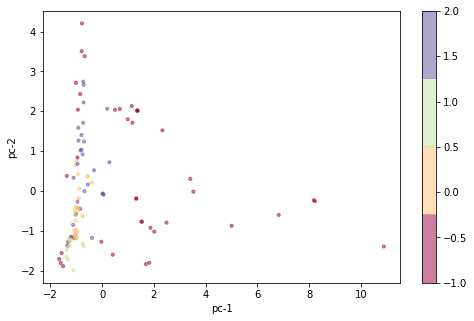

In [134]:
df_pca["cluster"] = X['cluster_HDBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

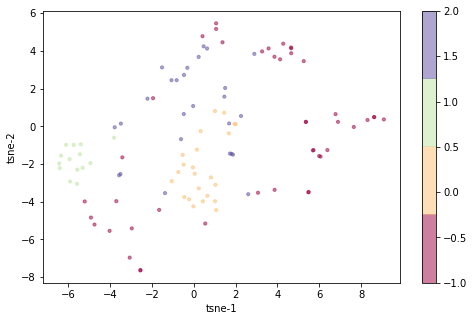

In [135]:
TSNE_cards["cluster"] = X['cluster_HDBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

**MNIST**

In [137]:
from sklearn import datasets

mnist = datasets.load_digits()
X, y = mnist.data, mnist.target

In [138]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [139]:
model_kmeans = KMeans(
    n_clusters=10,
    n_init=50,
    max_iter=500,
    random_state=42
)
model_kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=10, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [140]:
clust_num = model_kmeans.predict(X)
X['cluster_kmeans'] = clust_num

In [216]:
model_dbscan = DBSCAN(eps=28, min_samples=100)
model_dbscan.fit(X.iloc[:, X.columns != 'cluster_kmeans'])

DBSCAN(algorithm='auto', eps=28, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=100, n_jobs=None, p=None)

In [217]:
clust_num = pd.DataFrame( data = model_dbscan.labels_, columns = ['clust_num'])

In [218]:
clust_num.value_counts()

clust_num
-1           1327
 0            180
 1            168
 2            122
dtype: int64

In [215]:
y.value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

In [281]:
model_hdbscan = HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
model_hdbscan.fit(X.iloc[:, ~X.columns.isin(['cluster_kmeans'])])

/usr/local/lib/python3.7/dist-packages/hdbscan/hdbscan_.py:219: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=20, min_samples=None, p=None,
        prediction_data=False)

In [282]:
clust_num = pd.DataFrame( data = model_hdbscan.labels_, columns = ['clust_num'])

In [283]:
clust_num.value_counts()

clust_num
-1           953
 2           169
 3           144
 0           135
 1           112
 6           105
 7            74
 5            68
 4            37
dtype: int64

In [284]:
X['cluster_HDBSCAN'] = clust_num

In [256]:
pca = PCA(n_components = 2)

principal_components = pca.fit_transform(X.iloc[:, ~X.columns.isin(['cluster_kmeans', 'cluster_HDBSCAN'])] )

df_pca = pd.DataFrame(
        data=principal_components, 
        columns=[f'pc-{k}' for k in range(1, pca.n_components_+1)]
    )

df_pca.head()

,pc-1,pc-2
0,-1.259468,21.274883
1,7.957597,-20.768706
2,6.991930,-9.955983
3,-15.906106,3.332464
4,23.306859,4.269057


In [257]:
TSNE_cards = TSNE(n_components=2).fit_transform(X.iloc[:, ~X.columns.isin(['cluster_kmeans', 'cluster_HDBSCAN'])])

In [258]:
TSNE_cards = pd.DataFrame (data = TSNE_cards, columns = ['tsne-1', 'tsne-2'])


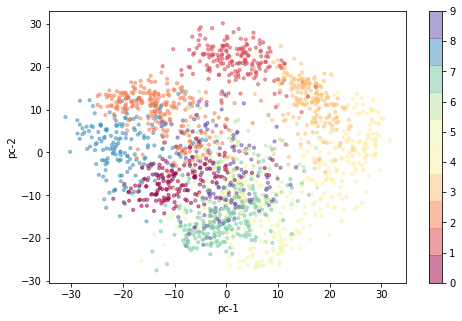

In [265]:
df_pca["cluster"] = X['cluster_kmeans']

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

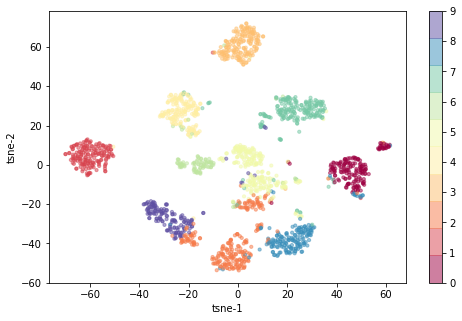

In [278]:
TSNE_cards["cluster"] = X['cluster_kmeans']

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=TSNE_cards["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', TSNE_cards["cluster"].nunique())
    )

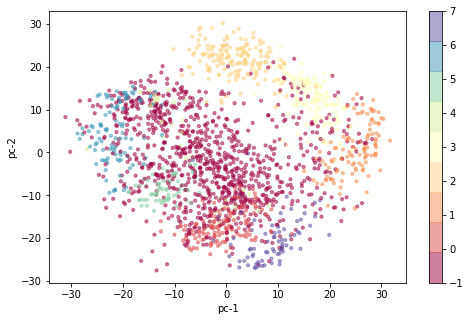

In [285]:
df_pca["cluster"] = X['cluster_HDBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

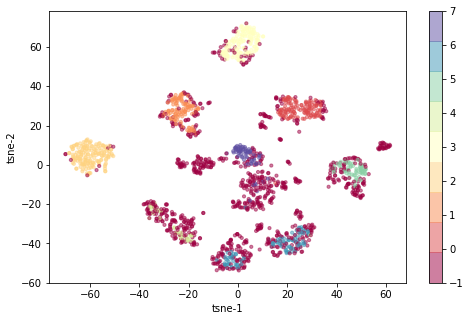

In [286]:
TSNE_cards["cluster"] = X['cluster_HDBSCAN']

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=TSNE_cards["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', TSNE_cards["cluster"].nunique())
    )

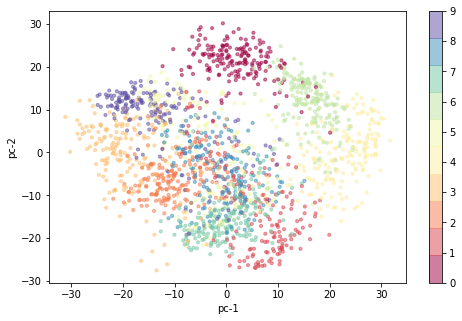

In [261]:
df_pca["cluster"] = y

fig, ax = plt.subplots(figsize = (8,5))
df_pca.plot(ax=ax, 
            kind="scatter", 
            x="pc-1", y="pc-2",
            c=df_pca["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', df_pca["cluster"].nunique())
    )

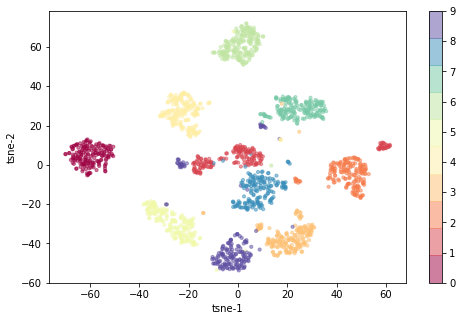

In [280]:
TSNE_cards["cluster"] = y[0]

fig, ax = plt.subplots(figsize = (8,5))
TSNE_cards.plot(ax=ax, 
            kind="scatter", 
            x="tsne-1", y="tsne-2",
            c=TSNE_cards["cluster"], 
#            edgecolor='none',
            s=10,
            alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', TSNE_cards["cluster"].nunique())
    )

In [275]:
y[0]

0       0
1       1
2       2
3       3
4       4
       ..
1792    9
1793    0
1794    8
1795    9
1796    8
Name: 0, Length: 1797, dtype: int64